## Annotate HD segments

For each each segment note whether it:
- overlaps a TSG (at least partially)
- overlaps a fragile site
- is telomere- or centromere-bound

In [1]:
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import random
import itertools
import re
import sys
sys.path.append("../1_data_processing")
import warnings
warnings.simplefilter("ignore")

import graphing_params as gp
import processing_utils as util
%load_ext autoreload
%autoreload 1
%aimport graphing_params
%aimport processing_utils

get_data_path = lambda folders, fname: os.path.normpath(os.environ['THIRD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

file_genes = get_local_data_path(['processed'], 'HGNC_gene_annot_ens93_hg19.csv')
folder_hd_maps = lambda fname: get_local_data_path(['processed','HD_maps'], fname)
file_fragsites = get_local_data_path(['processed'], 'hg19_fragile_sites.csv')
file_ascat_segment_bounds = get_local_data_path(['processed','TCGA','ASCAT'], 'segment_boundaries.csv')

### Load data

In [2]:
genes = pd.read_csv(file_genes)
passenger_genes = genes[~genes.TSG & ~genes.OG & ~genes.within_driver & ~genes.outside_bounds]
print('N genes:', genes.shape[0], passenger_genes.shape[0])

N genes: 17572 16898


In [3]:
tcga_hd_map = util.deserialize_map(folder_hd_maps("tcga_hd_map.csv"))

In [4]:
tcga_part_hd_map = util.deserialize_map(folder_hd_maps("tcga_part_hd_map.csv"))

In [5]:
tcga_hds = util.count_dels_per_gene(tcga_hd_map, genes)
tcga_hds = pd.merge(util.count_dels_per_gene(tcga_part_hd_map, genes)[['entrez_id','n_del']]\
                        .rename(columns={'n_del':'n_part_del'}), tcga_hds)

### 1. HDs overlapping TSGs

N. TSGs w/ 3+ HD: 77
N. TSGs w/ 1+ HD: 188
N. TSGs w/ 1+ partial HD: 221


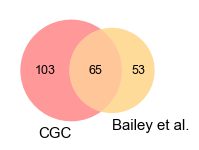

In [6]:
print('N. TSGs w/ 3+ HD:', tcga_hds[tcga_hds.TSG & (tcga_hds.n_del>=3)].shape[0])
print('N. TSGs w/ 1+ HD:', tcga_hds[tcga_hds.TSG & (tcga_hds.n_del>=1)].shape[0])
print('N. TSGs w/ 1+ partial HD:', tcga_hds[tcga_hds.TSG & (tcga_hds.n_part_del>=1)].shape[0])

hd_tsgs = tcga_hds[tcga_hds.TSG & (tcga_hds.n_part_del>=1)].reset_index(drop=True)

f, ax = plt.subplots(1, 1, figsize=(2, 1.8))
v = venn2([set(hd_tsgs[hd_tsgs.TSG_CGC].symbol.values), set(hd_tsgs[hd_tsgs.TSG_Bailey].symbol.values)],
          ('CGC', 'Bailey et al.'), set_colors=['red','orange'], ax=ax)

In [7]:
df = tcga_part_hd_map[['patient','chr','startpos','endpos','del_len','genes']].explode('genes')\
                     .rename(columns={'genes':'entrez_id'})
tsg_segments = df[df.entrez_id.isin(hd_tsgs.entrez_id)].drop(columns=['entrez_id']).drop_duplicates()

In [8]:
print('N TCGA HDs associated with TSGs: %d / %d = %.2f%%' % 
      (tsg_segments.shape[0], tcga_hd_map.shape[0], tsg_segments.shape[0]/tcga_hd_map.shape[0]*100))

N TCGA HDs associated with TSGs: 3126 / 11641 = 26.85%


### 2. Fragile sites

Fragile sites from PCAWG:  
Supplementary Table 5: Major fragile sites defined for the PCAWG dataset, in hg19 co-ordinates. Locations
(chromosome and co-ordinates) of major fragile sites, the genes containing the fragile site, and the name of
the fragile site. CFS, common fragile site.

In [9]:
fragsites = pd.read_csv(file_fragsites)

In [10]:
def identify_fragsite_HDs(del_segs, fragsites):
    fragsite_hds = pd.DataFrame()
    for row in fragsites.iterrows():
        # 1. Find segments that start or end in fragile site
        df = del_segs[(del_segs.chr==row[1]['chr']) &
                      (((del_segs.startpos>=row[1].startpos) & (del_segs.startpos<=row[1].endpos)) |
                       ((del_segs.endpos>=row[1].startpos) & (del_segs.endpos<=row[1].endpos)))]
        # 2. Find segments that fully overlap fragile sites
        df2 = del_segs[(del_segs.chr==row[1]['chr']) & 
                       (del_segs.startpos<=row[1].startpos) & (del_segs.endpos>=row[1].endpos)]
        fragsite_hds = pd.concat([fragsite_hds, df.assign(CFS_name=row[1].CFS_name), 
                                  df2.assign(CFS_name=row[1].CFS_name)]).drop_duplicates()
    return fragsite_hds

In [11]:
fragsite_segments = identify_fragsite_HDs(tcga_hd_map.drop(columns=['genes']), fragsites)
fragsite_segments = pd.merge(tcga_hd_map, fragsite_segments)
fragsite_segments['gene_del'] = fragsite_segments.genes.apply(lambda x: len(x)>0)

In [12]:
print('N TCGA HDs associated with fragile sites: %d / %d = %.2f%%' % 
      (fragsite_segments.shape[0], tcga_hd_map.shape[0], fragsite_segments.shape[0]/tcga_hd_map.shape[0]*100))
print('N fragile site HD segments that fully delete a gene:', fragsite_segments[fragsite_segments.gene_del].shape[0])
print('N total affected samples:', fragsite_segments['patient'].nunique())

N TCGA HDs associated with fragile sites: 1475 / 11641 = 12.67%
N fragile site HD segments that fully delete a gene: 52
N total affected samples: 913


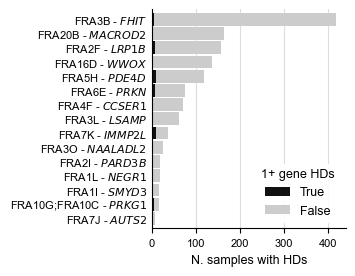

In [13]:
f, ax = plt.subplots(1, 1, figsize=(2.5, 2.9))
tab = fragsite_segments.groupby(['CFS_name','gene_del'])['patient'].nunique()
tab = pd.merge(tab.reset_index(), fragsites[['CFS_name','gene_name']])
tab.CFS_name = tab.CFS_name + ' - $\it{'+tab.gene_name+'}$'
tab = tab.pivot(index='CFS_name', columns='gene_del', values='patient')
tab['total'] = tab.sum(axis=1)
tab.sort_values('total').iloc[:,[1,0]].plot.barh(stacked=True, width=0.9, color=['#111','#ccc'], ax=ax); 
ax.legend(title='1+ gene HDs'); ax.grid(axis="x")
gp.set_axis_props(ax, xlabel='N. samples with HDs', ylabel='', show_yticks=False);
plt.savefig('../figures/fragile_site_HDs.png', bbox_inches='tight', dpi=400)

0.34Mb
0.83Mb
MannwhitneyuResult(statistic=6516852.0, pvalue=2.1481344966809573e-16)


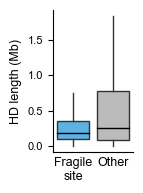

In [14]:
df = pd.merge(tcga_hd_map, fragsite_segments.drop(columns=['genes']), indicator=True, how='left')\
       .sort_values('_merge', ascending=False)
df['_merge'] = df['_merge'].apply(lambda x: 'Fragile\nsite' if x=='both' else 'Other')
print('%.2fMb' % (df[df._merge=='Fragile\nsite'].del_len.mean()/1000000))
print('%.2fMb' % (df[df._merge=='Other'].del_len.mean()/1000000))

f, ax = plt.subplots(1, 1, figsize=(1.5, 2))
sns.boxplot(y=df.del_len/1000000, x=df._merge, palette=[gp.get_color('sky-blue'),'#bbb'], ax=ax, showfliers=False, 
            **gp.get_boxplot_props())
gp.set_axis_props(ax, xlabel='', ylabel='HD length (Mb)', show_xticks=False, xtick_fontsize=9)
print(stats.mannwhitneyu(df[df._merge=='Other'].del_len, df[df._merge=='Fragile\nsite'].del_len))
plt.tight_layout()

### 3. Telomeres

In [15]:
ascat_seg_bounds = pd.read_csv(file_ascat_segment_bounds, index_col=0)

In [16]:
def identify_telomere_bound_HDs(del_segs):
    telomere_hds = pd.DataFrame()
    for chrom in range(1,23):
        # Don't check start bound for chromosomes 13,14,15,22 there are 0 segments on short arm for these chrs
        if not chrom in [13,14,15,22]:
            df1 = del_segs[(del_segs.chr==chrom) & 
                           (del_segs.startpos==ascat_seg_bounds.loc[chrom].startpos)].assign(telomere='start')
        else: df1 = pd.DataFrame()
        df2 = del_segs[(del_segs.chr==chrom) & 
                       (del_segs.endpos==ascat_seg_bounds.loc[chrom].endpos)].assign(telomere='end')
        telomere_hds = pd.concat([telomere_hds, df1, df2])
    return telomere_hds.drop_duplicates()

In [17]:
telomere_segments = identify_telomere_bound_HDs(tcga_hd_map.drop(columns=['genes']))

In [18]:
print('N HDs associated with telomeres: %d / %d = %.2f%%' % 
      (telomere_segments.shape[0], tcga_hd_map.shape[0], telomere_segments.shape[0]/tcga_hd_map.shape[0]*100))

N HDs associated with telomeres: 376 / 11641 = 3.23%


### 4. Centromeres

In [19]:
def identify_centromere_bound_HDs(del_segs):
    centromere_hds = pd.DataFrame()
    for chrom in range(1,23):
        # Find segments that start or end at last found bound after/before centromere
        # Don't check centromere start bound for chromosomes 13,14,15,22 (no short arm segments)
        if chrom in [13,14,15,22]:
            df = del_segs[(del_segs.chr==chrom) & 
                           (del_segs.startpos==ascat_seg_bounds.loc[chrom].cent_end)]
        else:
            df = del_segs[(del_segs.chr==chrom) & 
                          ((del_segs.startpos==ascat_seg_bounds.loc[chrom].cent_end) |
                           (del_segs.endpos==ascat_seg_bounds.loc[chrom].cent_start))]
        centromere_hds = pd.concat([centromere_hds, df])
    return centromere_hds

In [20]:
centromere_segments = identify_centromere_bound_HDs(tcga_hd_map.drop(columns=['genes']))

In [21]:
print('N HDs associated with centromere: %d / %d = %.2f%%' % 
      (centromere_segments.shape[0], tcga_hd_map.shape[0], centromere_segments.shape[0]/tcga_hd_map.shape[0]*100))

N HDs associated with centromere: 52 / 11641 = 0.45%


### Annotate HD map with segment types

In [22]:
cols = ['patient','chr','startpos','endpos']
hd_map_annot = pd.merge(tcga_hd_map, tsg_segments[cols], how='left', indicator='tsg')
hd_map_annot = pd.merge(hd_map_annot, fragsite_segments[cols], how='left', indicator='fragsite')
hd_map_annot = pd.merge(hd_map_annot, telomere_segments[cols], how='left', indicator='telomere')
hd_map_annot = pd.merge(hd_map_annot, centromere_segments[cols], how='left', indicator='centromere')
for col in ['tsg','fragsite','telomere','centromere']: 
    hd_map_annot[col] = hd_map_annot[col]=='both'
hd_map_annot['to_drop'] = hd_map_annot.tsg | hd_map_annot.fragsite | hd_map_annot.centromere | hd_map_annot.telomere
assert(hd_map_annot.shape[0] == tcga_hd_map.shape[0])

In [23]:
def calc_hd_event_for_cat(cat):
    #df = pd.merge(hd_map_an.drop(columns=['genes']), tcga_hds)
    gene_hds = hd_map_annot[hd_map_annot.genes.apply(lambda x: len(x)>0)]
    print('N HD events %s:\t%d = %.2f%%\t--- gene HDs: %d = %.2f%%' % 
          (cat, sum(hd_map_annot[cat]), sum(hd_map_annot[cat])/hd_map_annot.shape[0]*100, 
           sum(gene_hds[cat]), sum(gene_hds[cat])/gene_hds.shape[0]*100))

In [24]:
calc_hd_event_for_cat('tsg')
calc_hd_event_for_cat('fragsite')
calc_hd_event_for_cat('telomere')
calc_hd_event_for_cat('centromere')
calc_hd_event_for_cat('to_drop')

N HD events tsg:	3126 = 26.85%	--- gene HDs: 2236 = 49.35%
N HD events fragsite:	1475 = 12.67%	--- gene HDs: 52 = 1.15%
N HD events telomere:	376 = 3.23%	--- gene HDs: 303 = 6.69%
N HD events centromere:	52 = 0.45%	--- gene HDs: 45 = 0.99%
N HD events to_drop:	4367 = 37.51%	--- gene HDs: 2514 = 55.48%


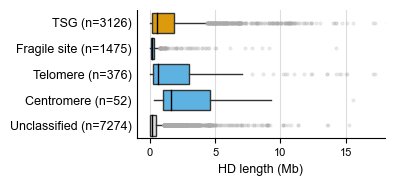

In [25]:
f, ax = plt.subplots(1, 1, figsize=(3.2, 1.7))
df = hd_map_annot
df = pd.concat([df[df.tsg].assign(t='TSG (n=3126)'), df[df.fragsite].assign(t='Fragile site (n=1475)'), 
                df[df.telomere].assign(t='Telomere (n=376)'), df[df.centromere].assign(t='Centromere (n=52)'), 
                df[df['to_drop']==False].assign(t='Unclassified (n=7274)')])

sns.boxplot(x=df.del_len/1000000, y=df.t, **gp.get_boxplot_props(), 
            palette=[gp.get_color('orange')]+[gp.get_color('sky-blue') for i in range(3)] + ['#ddd']);
gp.set_axis_props(ax, xlabel='HD length (Mb)', ylabel='', ytick_fontsize=9, show_yticks=False)
ax.grid(axis='x'); ax.set_xlim([-1,18]);
#plt.savefig('../figures/tcga_hd_length.png', bbox_inches='tight', dpi=500, transparent=True)

In [26]:
df['t'].value_counts()

Unclassified (n=7274)    7274
TSG (n=3126)             3126
Fragile site (n=1475)    1475
Telomere (n=376)          376
Centromere (n=52)          52
Name: t, dtype: int64

In [27]:
util.serialize_map(hd_map_annot, folder_hd_maps("tcga_hd_map_annot.csv"))